In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle
from scipy.stats import spearmanr, norm
try:
    from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
except:
    from sklearn.metrics import mean_squared_error, r2_score
import sys

#investigates the point scale LHS runs

In [ ]:
if 'win' in sys.platform:
    path = "E:/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/MiscTests/LHS/"
    df_val_og = pd.read_csv("E:/OneDrive/PhD/PhD/Data/Hintereisferner/Climate/AWS_Obleitner/cosipy_validation_upper_station.csv", parse_dates=True, index_col="time")
else:
    path = "/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/MiscTests/LHS/"
    df_val_og = pd.read_csv("/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/Climate/AWS_Obleitner/cosipy_validation_upper_station.csv", parse_dates=True, index_col="time")

print(df_val_og.albedo.min())
print(df_val_og)
#resample to weekly to reduce data points for now
df_val = df_val_og.resample("1D").agg({'LWout': np.nanmean, 'SR50': "last", 'albedo': np.nanmin}) ##!! SR50 is not sum but last

unc_alb = 0.03
unc_sfc = 0.1
unc_lwo = 5

if 'win' in sys.platform:
    df = pd.read_csv("E:/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/pointLHS-parameters_full.csv")
else:
    df = pd.read_csv("/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/pointLHS-parameters_full.csv")
#df = pd.read_csv(path+"pointLHS-parameters_full.csv")
## get rid of redudant variables
params = df.drop(['chain','like1'], axis=1)
params['parRRR_factor'] = np.exp(params['parRRR_factor'])
params['num'] = np.arange(3, len(params)+3)
params

In [ ]:
sns.pairplot(params[['parRRR_factor', 'paralb_ice', 'paralb_snow', 'paralb_firn', 'paralbedo_aging', 'paralbedo_depth', 'parroughness_ice']])

In [ ]:
# This script at daily resolution doesn't change anything. Was designed for experimenting with weekly or monthly resolutions
param_cols = [col for col in params.columns if not col.startswith('simulation')]
sim_cols = [col for col in params.columns if col.startswith('simulation')]

print(f"Param cols: {len(param_cols)}, Sim cols: {len(sim_cols)}")  # sim_cols should be 1098

#
sim_len = 366  # days per simulation
simulation1_cols = sim_cols[0:sim_len]
simulation2_cols = sim_cols[sim_len:2*sim_len]
simulation3_cols = sim_cols[2*sim_len:3*sim_len]

#Create date index for daily data
dates = pd.date_range(start='2003-10-01', periods=sim_len, freq='D')

def resample_simulation(simulation_cols, sim_name, agg):
    sim_df = params[simulation_cols].copy()
    sim_df.columns = dates  # assign dates as columns
    
    # Resample daily
    if agg == "mean":
        weekly_df = sim_df.resample('1D', axis=1).mean()
    elif agg == "min":
        weekly_df = sim_df.resample('1D', aixs=1).min()
    else:
        weekly_df = sim_df.resample('1D', axis=1).last() #is already a cumulative measure
    
    # Rename columnsY
    weekly_colnames = [f"{sim_name}_week{week+1}" for week in range(len(weekly_df.columns))]
    weekly_df.columns = weekly_colnames
    
    return weekly_df

#
weekly_sim1 = resample_simulation(simulation1_cols, "simulation1", "mean") #lwo
weekly_sim2 = resample_simulation(simulation2_cols, "simulation2", "mean") #alb
weekly_sim3 = resample_simulation(simulation3_cols, "simulation3", "last") #sfc

# Concatenate parameter columns and all resampled simulations

final_df = pd.concat([params[param_cols], weekly_sim1, weekly_sim2, weekly_sim3], axis=1)

print(final_df.shape)

In [ ]:
sim_sfc_cols = [col for col in final_df.columns if col.startswith('simulation3_')]
sim_alb_cols = [col for col in final_df.columns if col.startswith('simulation2_')]
sim_lwo_cols = [col for col in final_df.columns if col.startswith('simulation1_')]
df_sfc_subset = final_df[sim_sfc_cols].copy()
df_alb_subset = final_df[sim_alb_cols].copy()
df_lwo_subset = (final_df[sim_lwo_cols]*-1).copy()
df_lwo_subset

In [7]:
def loglike_tsla_func(sim_tsla, eval_tsla, sigma_tsla):
    loglike_tsla = -0.5 * np.sum(np.log(2 * np.pi * sigma_tsla**2) + ((eval_tsla-sim_tsla)**2 / sigma_tsla**2))
    avg_loglike_tsla = loglike_tsla / len(eval_tsla)
    return avg_loglike_tsla

def rmse_func(sim_tsla, eval_tsla):
    sim = np.asarray(sim_tsla)
    obs = np.asarray(eval_tsla)
    squared_diff = (sim-obs)**2
    mean_squared_diff = np.mean(squared_diff)
    rmse = np.sqrt(mean_squared_diff)
    return rmse


logl_sfc = df_sfc_subset.apply(lambda row: loglike_tsla_func(row.values, df_val['SR50'].values, unc_sfc), axis=1)
logl_alb = df_alb_subset.apply(lambda row: loglike_tsla_func(row.values, df_val['albedo'].values, unc_alb), axis=1)
logl_lwo = df_lwo_subset.apply(lambda row: loglike_tsla_func(row.values, df_val['LWout'].values, unc_lwo), axis=1)
#
rmse_sfc = df_sfc_subset.apply(lambda row: rmse_func(row.values, df_val['SR50'].values), axis=1)
rmse_alb = df_alb_subset.apply(lambda row: rmse_func(row.values, df_val['albedo'].values), axis=1)
rmse_lwo = df_lwo_subset.apply(lambda row: rmse_func(row.values, df_val['LWout'].values), axis=1)

df_sfc_subset['logp_sfc'] = logl_sfc
df_alb_subset['logp_alb'] = logl_alb
df_lwo_subset['logp_lwo'] = logl_lwo
#
df_sfc_subset['rmse_sfc'] = rmse_sfc
df_alb_subset['rmse_alb'] = rmse_alb
df_lwo_subset['rmse_lwo'] = rmse_lwo

In [ ]:
logl_df = pd.concat([df_sfc_subset['logp_sfc'],df_alb_subset['logp_alb'],df_lwo_subset['logp_lwo']], axis=1)
rmse_df = pd.concat([df_sfc_subset['rmse_sfc'],df_alb_subset['rmse_alb'],df_lwo_subset['rmse_lwo']], axis=1)

## standardize scores
logl_df['z_logp_sfc'] = (logl_df['logp_sfc'] - logl_df['logp_sfc'].mean()) / logl_df['logp_sfc'].std()
logl_df['z_logp_alb'] = (logl_df['logp_alb'] - logl_df['logp_alb'].mean()) / logl_df['logp_alb'].std()
logl_df['z_logp_lwo'] = (logl_df['logp_lwo'] - logl_df['logp_lwo'].mean()) / logl_df['logp_lwo'].std()

logl_df['logp_joint'] = logl_df['z_logp_sfc'] + logl_df['z_logp_alb'] + logl_df['z_logp_lwo']
#
## standardize scores
rmse_df['z_rmse_sfc'] = (rmse_df['rmse_sfc'] - rmse_df['rmse_sfc'].mean()) / rmse_df['rmse_sfc'].std()
rmse_df['z_rmse_alb'] = (rmse_df['rmse_alb'] - rmse_df['rmse_alb'].mean()) / rmse_df['rmse_alb'].std()
rmse_df['z_rmse_lwo'] = (rmse_df['rmse_lwo'] - rmse_df['rmse_lwo'].mean()) / rmse_df['rmse_lwo'].std()

rmse_df['rmse_joint'] = rmse_df['z_rmse_sfc'] + rmse_df['z_rmse_alb'] + rmse_df['z_rmse_lwo']
logl_df

In [11]:
stats_only = logl_df.sort_values(by='logp_joint', ascending=False).head(50)

stats_mean_sfc = stats_only['logp_sfc'].mean()
stats_std_sfc = stats_only['logp_sfc'].std()
#
stats_mean_alb = stats_only['logp_alb'].mean()
stats_std_alb = stats_only['logp_alb'].std()
#
stats_mean_lwo = stats_only['logp_lwo'].mean()
stats_std_lwo = stats_only['logp_lwo'].std()

all_stats = {
    "sfc_mean": stats_mean_sfc,
    "sfc_std": stats_std_sfc,
    "alb_mean": stats_mean_alb,
    "alb_std": stats_std_alb,
    "lwo_mean": stats_mean_lwo,
    "lwo_std": stats_std_lwo
}



# Save to pickle
if 'win' in sys.platform:
    with open("E:/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/MiscTests/LHS/LHS/point_loglike_stats.pkl", "wb") as f:
        pickle.dump(all_stats, f)
else:
    with open("/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/MiscTests/LHS/LHS/point_loglike_stats.pkl", "wb") as f:
        pickle.dump(all_stats, f)


In [12]:
stats_only = rmse_df.sort_values(by="rmse_joint", ascending=True).head(50)

stats_mean_sfc = stats_only['rmse_sfc'].mean()
stats_std_sfc = stats_only['rmse_sfc'].std()
#
stats_mean_alb = stats_only['rmse_alb'].mean()
stats_std_alb = stats_only['rmse_alb'].std()
#
stats_mean_lwo = stats_only['rmse_lwo'].mean()
stats_std_lwo = stats_only['rmse_lwo'].std()

all_stats = {
    "sfc_mean": stats_mean_sfc,
    "sfc_std": stats_std_sfc,
    "alb_mean": stats_mean_alb,
    "alb_std": stats_std_alb,
    "lwo_mean": stats_mean_lwo,
    "lwo_std": stats_std_lwo
}

## Store means/stds of best RMSE scores. Aren't really used anymore.

import pickle
# Save to pickle
if 'win' in sys.platform:
    with open("E:/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/MiscTests/LHS/LHS/point_rmse_stats.pkl", "wb") as f:
        pickle.dump(all_stats, f)
else:
    with open("/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/MiscTests/LHS/LHS/point_rmse_stats.pkl", "wb") as f:
        pickle.dump(all_stats, f)

In [ ]:
#best_5 = logl_df.sort_values(by='logp_joint', ascending=False).head(50) #best 2%
#best_5.head()
best_5 = rmse_df.sort_values(by='rmse_joint', ascending=True).head(50) #best 2%
best_5.head()

In [15]:
indices = best_5.index
#best_sfc = df_sfc_subset.iloc[indices].drop('logp_sfc', axis=1)
#best_alb = df_alb_subset.iloc[indices].drop('logp_alb', axis=1)
#best_lwo = df_lwo_subset.iloc[indices].drop('logp_lwo', axis=1)
best_sfc = df_sfc_subset.iloc[indices].drop(['rmse_sfc','logp_sfc'], axis=1)
best_alb = df_alb_subset.iloc[indices].drop(['rmse_alb','logp_alb'], axis=1)
best_lwo = df_lwo_subset.iloc[indices].drop(['rmse_lwo','logp_lwo'], axis=1)


In [ ]:
#best_logl = logl_df.iloc[indices]
#best_logl
best_rmse = rmse_df.iloc[indices]
best_rmse

In [ ]:
def weighted_mean(vals, weights):
    return np.average(vals, weights=weights, axis=0)

def weighted_std_dev(vals, weighted_mean, weights):
    # First, get the variance manually
    variance = np.average((vals - weighted_mean) ** 2, weights=weights, axis=0)
    weighted_std = np.sqrt(variance)
    return weighted_std

#print("Weighted Mean:", weighted_mean(best_sfc, best_logl['logp_joint'].values))
#print("Weighted Std Dev:", weighted_std_dev(best_sfc, weighted_mean(best_sfc, best_logl['logp_joint'].values), best_logl['logp_joint'].values))
print("Weighted Mean:", weighted_mean(best_sfc, best_rmse['rmse_joint'].values))
print("Weighted Std Dev:", weighted_std_dev(best_sfc, weighted_mean(best_sfc, best_rmse['rmse_joint'].values), best_rmse['rmse_joint'].values))

In [18]:
## Build ensemble stats
"""
sfc_mean = weighted_mean(best_sfc, best_logl['logp_joint'].values)
sfc_std = weighted_std_dev(best_sfc, sfc_mean, best_logl['logp_joint'].values)
#
alb_mean = weighted_mean(best_alb, best_logl['logp_joint'].values)
alb_std = weighted_std_dev(best_alb, alb_mean, best_logl['logp_joint'].values)
#
lwo_mean = weighted_mean(best_lwo, best_logl['logp_joint'].values)
lwo_std = weighted_std_dev(best_lwo, lwo_mean, best_logl['logp_joint'].values)
"""
sfc_mean = weighted_mean(best_sfc, best_rmse['rmse_joint'].values)
sfc_std = weighted_std_dev(best_sfc, sfc_mean, best_rmse['rmse_joint'].values)
#
alb_mean = weighted_mean(best_alb, best_rmse['rmse_joint'].values)
alb_std = weighted_std_dev(best_alb, alb_mean, best_rmse['rmse_joint'].values)
#
lwo_mean = weighted_mean(best_lwo, best_rmse['rmse_joint'].values)
lwo_std = weighted_std_dev(best_lwo, lwo_mean, best_rmse['rmse_joint'].values)

## Normal mean ##
#sfc_mean = best_sfc.mean(axis=0).values
#sfc_std = best_sfc.std(axis=0).values
#
#alb_mean = best_alb.mean(axis=0).values
#alb_std = best_alb.std(axis=0).values
#
#lwo_mean = best_lwo.mean(axis=0).values
#lwo_std = best_lwo.std(axis=0).values

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(3,1, figsize=(16,9), dpi=300, sharex=True)
ax[0].plot(df_val.index, df_val['SR50'], label="Obs.", color="black")
ax[0].plot(df_val.index, sfc_mean, label="ENS MEAN", color="red")
ax[0].fill_between(df_val.index, y1=sfc_mean-sfc_std, y2=sfc_mean+sfc_std, alpha=0.3, facecolor="red")
ax[0].set_ylabel("SFC (m)")
ax[0].grid()
#
ax[1].plot(df_val.index, df_val['LWout'], label="Obs.", color="black")
ax[1].plot(df_val.index, lwo_mean, label="ENS MEAN", color="red")
ax[1].fill_between(df_val.index, y1=lwo_mean-lwo_std, y2=lwo_mean+lwo_std, alpha=0.3, facecolor="red")
ax[1].set_ylabel("LWout (Wm$^{-2}$)")
ax[1].grid()
ax[1].legend()
#
ax[2].plot(df_val.index, df_val['albedo'], label="Obs.", color="black")
ax[2].plot(df_val.index, alb_mean, label="ENS MEAN", color="red")
ax[2].fill_between(df_val.index, y1=alb_mean-alb_std, y2=alb_mean+alb_std, alpha=0.3, facecolor="red")
ax[2].set_ylabel("Albedo (-)")
ax[2].grid()
#

def calc_metrics(obs, mod):
    try:
        rmse = root_mean_squared_error(obs, mod)
    except:
        rmse = mean_squared_error(obs, mod, squared=False)
    r2 = r2_score(obs, mod)
    print(rmse,r2)
    return (rmse,r2)

rmse, r2 = calc_metrics(df_val['LWout'], lwo_mean)
ax[1].annotate("R²: " +str(round(r2,2))+",\nRMSE: "+str(round(rmse,2))+"Wm$^{-2}$", xy=(0.55, 0.2), xytext=(0.55, 0.2),
                textcoords='axes fraction', xycoords='axes fraction', size=20)
rmse, r2 = calc_metrics(df_val['albedo'], alb_mean)
ax[2].annotate("R²: " +str(round(r2,2))+",\nRMSE: "+str(round(rmse,2))+"Wm$^{-2}$", xy=(0.55, 0.2), xytext=(0.55, 0.2),
                   textcoords='axes fraction', xycoords='axes fraction', size=20)
rmse, r2 = calc_metrics(df_val['SR50'], sfc_mean)
ax[0].annotate("R²: {},\nRMSE: {}".format(round(r2, 2), round(rmse,2)), xy=(0.3, 0.2), xytext=(0.3, 0.2),
                   textcoords='axes fraction', xycoords='axes fraction', size=20)

#highlight events from Schrott thesis
# Highlight a specific time range
ax[0].axvspan(pd.Timestamp('2003-10-04'), pd.Timestamp('2003-10-06'), 
           color='orange', alpha=0.3, label='Event Period')
ax[0].axvspan(pd.Timestamp('2003-12-15'), pd.Timestamp('2003-12-17'), 
           color='orange', alpha=0.3, label='Event Period')
ax[0].axvspan(pd.Timestamp('2004-04-29'), pd.Timestamp('2004-05-07'), 
           color='orange', alpha=0.3, label='Event Period')
fig.tight_layout()


In [20]:
subset = df.iloc[indices]
weights = best_rmse['rmse_joint'].values

x_label_dict = {'parRRR_factor': r'$p_{f}$', 'paralb_ice': r'$\alpha_{ice}$', 'paralb_snow': r'$\alpha_{fs}$','paralb_firn': r'$\alpha_{firn}$', 'paralbedo_aging': r'$\alpha_{aging}$',
                'paralbedo_depth': r'$\alpha_{depth}$','parroughness_ice': r'$z0_{ice}$', 'parcenter_snow_transfer_function': r'$T_{50}$'}

In [ ]:
## Hist of parameters
fig, axes = plt.subplots(4,2, figsize=(16,9), dpi=300)
axes[0,0].hist(np.exp(subset['parRRR_factor']), bins=25, weights=weights, edgecolor="black")
axes[0,0].set_ylabel("Count")
axes[0,0].set_xlabel(x_label_dict['parRRR_factor'])
axes[0,1].hist(subset['paralb_ice'], bins=25, weights=weights, edgecolor="black")
axes[0,1].set_xlabel(x_label_dict['paralb_ice'])
#
axes[1,0].hist(subset['paralb_snow'], bins=25, weights=weights, edgecolor="black")
axes[1,0].set_ylabel("Count")
axes[1,0].set_xlabel(x_label_dict['paralb_snow'])
axes[1,1].hist(subset['paralb_firn'], bins=25, weights=weights, edgecolor="black")
axes[1,1].set_xlabel(x_label_dict['paralb_firn'])
#
axes[2,0].hist(subset['paralbedo_aging'], bins=25, weights=weights, edgecolor="black")
axes[2,0].set_ylabel("Count")
axes[2,0].set_xlabel(x_label_dict['paralbedo_aging'])
axes[2,1].hist(subset['paralbedo_depth'], bins=25, weights=weights, edgecolor="black")
axes[2,1].set_xlabel(x_label_dict['paralbedo_depth'])
#
axes[3,0].hist(subset['parroughness_ice'], bins=25, weights=weights, edgecolor="black")
axes[3,0].set_ylabel("Count")
axes[3,0].set_xlabel(x_label_dict['parroughness_ice'])
#axes[3,1].hist(subset['parcenter_snow_transfer_function'], bins=25, weights=weights, edgecolor="black")
#axes[3,1].set_xlabel(x_label_dict['parcenter_snow_transfer_function'])
#
fig.tight_layout()

In [22]:
def bias_tsla_func(sim_tsla, eval_tsla):
    # The logic is identical to the albedo function.
    mean_bias = np.mean(sim_tsla.values - eval_tsla.values)
    return mean_bias

lwo_bias = df_lwo_subset.drop(['logp_lwo','rmse_lwo'], axis=1).apply(bias_tsla_func, eval_tsla=df_val['LWout'], axis=1)
sfc_bias = df_sfc_subset.drop(['logp_sfc','rmse_sfc'], axis=1).apply(bias_tsla_func, eval_tsla=df_val['SR50'], axis=1)
alb_bias = df_alb_subset.drop(['logp_alb','rmse_alb'], axis=1).apply(bias_tsla_func, eval_tsla=df_val['albedo'], axis=1)



In [ ]:
final_df['lwo_bias'] = lwo_bias
final_df['sfc_bias'] = sfc_bias
final_df['alb_bias'] = alb_bias
final_df

In [24]:
logp_analysis = False
df_copy = final_df.copy()
if logp_analysis:

    ## Do the 3-sigma filtering and repeat the spearman correlation analysis -- equifinality at point scale?

    def compute_nroy_threshold(model_outputs, observations, sigmas, scale=0, delta_sigma=3, return_mask=False, clip=False):
        """
        Computes a log-likelihood threshold corresponding to a full delta_sigma deviation.
        Optionally returns a mask of runs considered Not-Ruled-Out-Yet (NROY).

        Parameters:
        - model_outputs: np.ndarray, shape (n_runs, n_points)
        - observations: np.ndarray, shape (n_points,)
        - sigmas: np.ndarray, shape (n_points,) or (n_runs, n_points)
        - scale: float, optional log-likelihood adjustment
        - delta_sigma: float, e.g. 3 for ±3σ shift
        - return_mask: bool, whether to return accepted run indices

        Returns:
        - threshold: float, LL threshold (average LL)
        - best_avg_ll: float, best average LL score
        - nroy_mask: np.ndarray, optional boolean array of accepted runs
        """
        model_outputs = np.asarray(model_outputs)
        observations = np.asarray(observations)
        sigmas = np.asarray(sigmas)

        n_runs, n_points = model_outputs.shape

        if sigmas.ndim == 0:
            sigmas = np.full((n_runs, n_points), sigmas)  # scalar to full array
        elif sigmas.ndim == 1:
            sigmas = np.tile(sigmas, (n_runs, 1))  # repeat across runs

        # Compute LL for all runs
        ll_all = norm.logpdf(model_outputs, loc=observations, scale=sigmas)
        avg_ll_per_run = np.mean(ll_all, axis=1) + scale

        # Best run index and score
        best_idx = np.argmax(avg_ll_per_run)
        best_ll = avg_ll_per_run[best_idx]

        # Shift observations by ±delta_sigma * sigma and re-evaluate LL
        shifted_high = model_outputs[best_idx] + delta_sigma * sigmas[best_idx]
        shifted_low  = model_outputs[best_idx] - delta_sigma * sigmas[best_idx]

        # Clip if physical bounds (e.g. snowlines can’t be negative)
        #for snowlines we'd need to clip it to physical range (0,1)
        if clip:
            shifted_high = np.clip(shifted_high, 0, 1)
            shifted_low  = np.clip(shifted_low, 0, 1)

        ll_shifted_high = norm.logpdf(shifted_high, loc=observations, scale=sigmas[best_idx])
        ll_shifted_low  = norm.logpdf(shifted_low,  loc=observations, scale=sigmas[best_idx])

        drop_high = best_ll - (np.mean(ll_shifted_high) + scale)
        drop_low  = best_ll - (np.mean(ll_shifted_low)  + scale)
        drop_avg  = (drop_high + drop_low) / 2.0

        # Define threshold
        threshold = best_ll - drop_avg

        if return_mask:
            nroy_mask = avg_ll_per_run >= threshold
            return threshold, best_ll, nroy_mask

        return drop_high, drop_low, drop_avg, best_idx, best_ll

In [25]:
if logp_analysis:
    drop_high, drop_low, drop_avg, best_idx, best_ll = compute_nroy_threshold(
        df_sfc_subset.drop('logp_sfc', axis=1), df_val['SR50'], unc_sfc, scale=0, delta_sigma=2, return_mask=False, clip=False)

    print(f"Best run index: {best_idx}")
    print(f"Best avg log-likelihood: {best_ll:.4f}")
    print(f"Avg. Log-likelihood drop at +3σ: {drop_avg:.4f}")
    print(f"High Log-likelihood drop at +3σ: {drop_high:.4f}")
    print(f"Low Log-likelihood drop at +3σ: {drop_low:.4f}")

In [26]:
if logp_analysis:
    drop_high, drop_low, drop_avg, best_idx, best_ll = compute_nroy_threshold(
        df_alb_subset.drop('logp_alb', axis=1), df_val['albedo'], unc_alb, scale=0, delta_sigma=2, return_mask=False, clip=False)

    print(f"Best run index: {best_idx}")
    print(f"Best avg log-likelihood: {best_ll:.4f}")
    print(f"Avg. Log-likelihood drop at +3σ: {drop_avg:.4f}")
    print(f"High Log-likelihood drop at +3σ: {drop_high:.4f}")
    print(f"Low Log-likelihood drop at +3σ: {drop_low:.4f}")

In [27]:
if logp_analysis:
    drop_high, drop_low, drop_avg, best_idx, best_ll = compute_nroy_threshold(
        df_lwo_subset.drop('logp_lwo', axis=1), df_val['LWout'], unc_lwo, scale=0, delta_sigma=2, return_mask=False, clip=False)

    print(f"Best run index: {best_idx}")
    print(f"Best avg log-likelihood: {best_ll:.4f}")
    print(f"Avg. Log-likelihood drop at +3σ: {drop_avg:.4f}")
    print(f"High Log-likelihood drop at +3σ: {drop_high:.4f}")
    print(f"Low Log-likelihood drop at +3σ: {drop_low:.4f}")

In [ ]:
if logp_analysis:
    df_copy['logp_sfc'] = df_sfc_subset['logp_sfc']
    df_copy['logp_alb'] = df_alb_subset['logp_alb']
    df_copy['logp_lwo'] = df_lwo_subset['logp_lwo']
    df_copy['joint_like'] = df_copy['logp_sfc'] + df_copy['logp_alb'] + df_copy['logp_lwo']
else:
    df_copy['rmse_sfc'] = df_sfc_subset['rmse_sfc']
    df_copy['rmse_alb'] = df_alb_subset['rmse_alb']
    df_copy['rmse_lwo'] = df_lwo_subset['rmse_lwo']
    
    df_copy['z_rmse_sfc'] = (df_copy['rmse_sfc'] - df_copy['rmse_sfc'].mean()) / df_copy['rmse_sfc'].std()
    df_copy['z_rmse_alb'] = (df_copy['rmse_alb'] - df_copy['rmse_alb'].mean()) / df_copy['rmse_alb'].std()
    df_copy['z_rmse_lwo'] = (df_copy['rmse_lwo'] - df_copy['rmse_lwo'].mean()) / df_copy['rmse_lwo'].std()

    df_copy['joint_rmse'] = df_copy['z_rmse_sfc'] + df_copy['z_rmse_alb'] + df_copy['z_rmse_lwo']
    #df_copy['joint_rmse'] = df_copy['rmse_sfc'] + df_copy['rmse_alb'] + df_copy['rmse_lwo']
df_copy

In [ ]:
## How to use thresholds to adjust it for min/max? 
#normalize threshold score
## construct conservative cutoff-threshold - 3sigma
if logp_analysis:
    sr50_cutoff = -0.1362 - 5.5223
    alb_cutoff = -3.8574 - 5.2739
    lwo_cutoff = -7.3024 - 4.5095 #4.5 

    # 2 sigma cutoff
    #sr50_cutoff = -0.1362 - 2.6816
    #alb_cutoff = -3.8574 - 2.5159
    #lwo_cutoff = -7.3024 - 2.0063 #4.5 

    cutoff_thres = sr50_cutoff + alb_cutoff + lwo_cutoff
        
    filtered_data = df_copy.loc[df_copy['joint_like'] >= cutoff_thres]
else:
    #try the 10% from best score
    best_score = df_copy['joint_rmse'].min()
    max_score = df_copy['joint_rmse'].max()
    q_score = df_copy['joint_rmse'].quantile(0.9)
    
    # The threshold is 10% worse than the best score.
    tolerance = 0.10
    threshold = best_score + (abs(best_score) * tolerance)
    
    filtered_data = df_copy.loc[df_copy['joint_rmse'] <= threshold]
filtered_data

In [ ]:
#normalise the scores again
scale_logps = True

if scale_logps:
    
    # =============================================================================
    # Simulated log-likelihood scores (you already have these from real data)
    # =============================================================================

    L_sfc = filtered_data['rmse_sfc'].copy()
    L_lwo = filtered_data['rmse_lwo'].copy()
    L_albedo = filtered_data['rmse_alb'].copy()

    # =============================================================================
    # Descriptive statistics
    # =============================================================================
    def describe_scores(scores, label):
        stats = {
            'min': np.min(scores),
            'max': np.max(scores),
            'median': np.median(scores),
            'mean': np.mean(scores),
            'std': np.std(scores),
            'range': np.max(scores) - np.min(scores)
        }
        print(f"Statistics for {label}:")
        for key, value in stats.items():
            print(f" {key:>6}: {value:8.2f}")
        print()
        return stats

    print("Raw Statistics:")
    stats_snow   = describe_scores(L_sfc,  "SR50")
    stats_mass   = describe_scores(L_lwo,  "LWO")
    stats_albedo = describe_scores(L_albedo,"Albedo")

    # =============================================================================
    # Median shift
    # =============================================================================
    L_sfc_shifted   = L_sfc - stats_snow['mean']
    L_lwo_shifted   = L_lwo - stats_mass['mean']
    L_albedo_shifted = L_albedo - stats_albedo['mean']

    print("After Median Shift:")
    describe_scores(L_sfc_shifted, "SR50 (Shifted)")
    describe_scores(L_lwo_shifted, "LWO (Shifted)")
    describe_scores(L_albedo_shifted, "Albedo (Shifted)")

    # =============================================================================
    # Standardization: shift + scale (std and MAD versions)
    # =============================================================================
    L_sfc_std   = L_sfc_shifted / stats_snow['std']
    L_lwo_std   = L_lwo_shifted / stats_mass['std']
    L_albedo_std = L_albedo_shifted / stats_albedo['std']

    # =============================================================================
    # Plotting: raw and standardized
    # =============================================================================
    plt.figure(figsize=(18, 12))  # Increase height to accommodate the third row

    # Row 1 - Original
    plt.subplot(3, 3, 1)
    sns.histplot(L_sfc, bins=40, kde=True, color='skyblue')
    plt.title("TSLA (Raw)")

    plt.subplot(3, 3, 2)
    sns.histplot(L_lwo, bins=40, kde=True, color='lightgreen')
    plt.title("MB (Raw)")

    plt.subplot(3, 3, 3)
    sns.histplot(L_albedo, bins=40, kde=True, color='salmon')
    plt.title("Alb (Raw)")

    plt.subplot(3, 3, 4)
    sns.histplot(L_sfc_shifted, bins=40, kde=True, color='skyblue')
    plt.title("TSLA (Shifted)")

    plt.subplot(3, 3, 5)
    sns.histplot(L_lwo_shifted, bins=40, kde=True, color='lightgreen')
    plt.title("MB (Shifted)")

    plt.subplot(3, 3, 6)
    sns.histplot(L_albedo_shifted, bins=40, kde=True, color='salmon')
    plt.title("Alb (Shifted)")
    
    # Row 3 - Standardized by STD
    plt.subplot(3, 3, 7)
    sns.histplot(L_sfc_std, bins=40, kde=True, color='skyblue')
    plt.title("TSLA (Standardized+Shifted)")

    plt.subplot(3, 3, 8)
    sns.histplot(L_lwo_std, bins=40, kde=True, color='lightgreen')
    plt.title("MB (Standardized+Shifted)")

    plt.subplot(3, 3, 9)
    sns.histplot(L_albedo_std, bins=40, kde=True, color='salmon')
    plt.title("Alb (Standardized+Shifted)")

    plt.tight_layout()

    # Optional: MAD-standardized plots if you want to compare
    # Comment out the above plot and uncomment the block below if you prefer MAD

    
    filtered_data.loc[:,'rmse_sfc'] = L_sfc_std
    filtered_data.loc[:,'rmse_lwo'] = L_lwo_std
    filtered_data.loc[:,'rmse_alb'] = L_albedo_std

Figure from Schrott: Forcing SOMARS with AWS.
He highlights five crucial events, three of which are relevant for us
- 05.10.2003: erosion, 30cm new snow, low density snow blown off by strong northern foehn event (T < 0°C, little radiation and wind speed up to 17m/s); at lower station same event but not blown off due to higher temperature and higher snow density
- 16.12.2003: eorison, 20cm new snow
- 30.04 - 06.05.2004: underestimated new snowfall, high amount, low intensity avg. 1cm/h

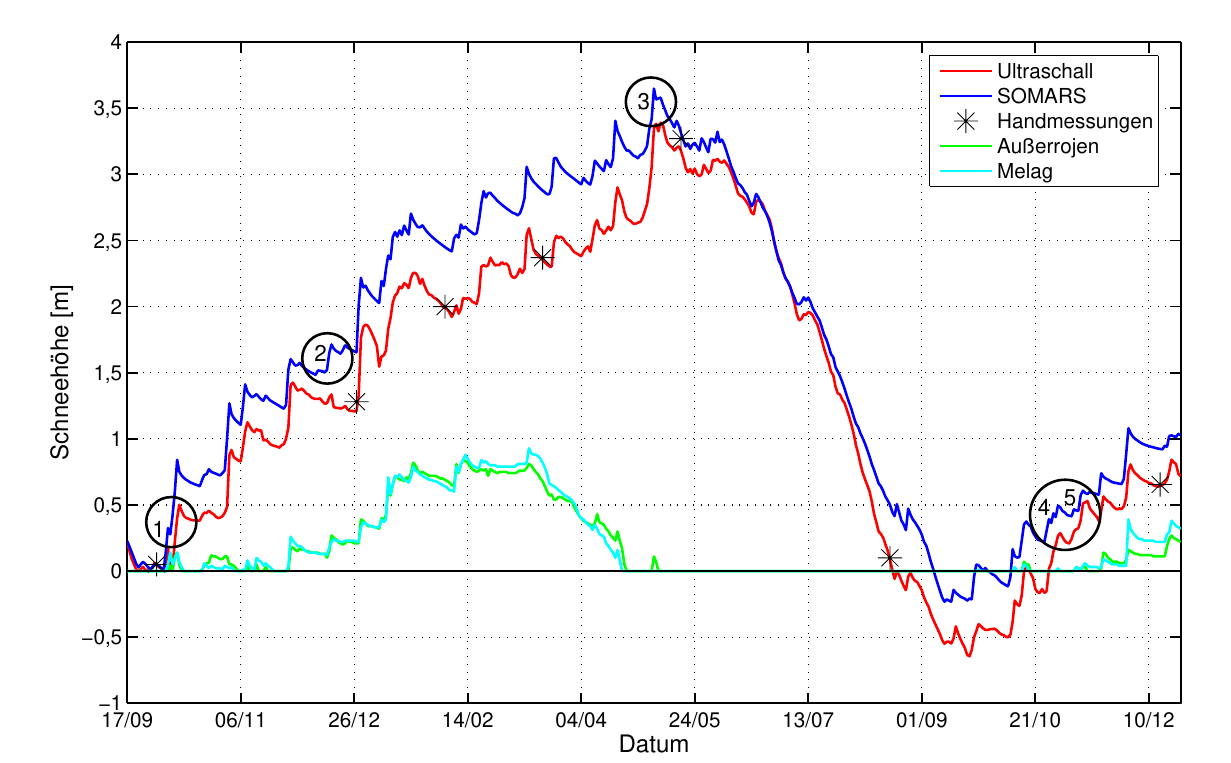

Second run, correction for the five highlighted events.
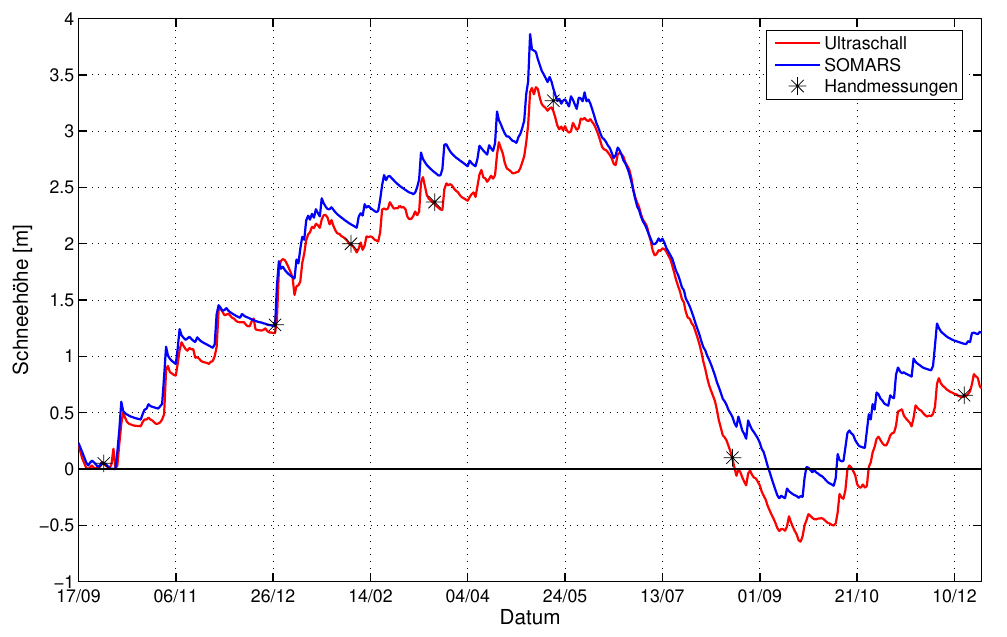

In [ ]:

# Define the columns for correlation
cols_to_correlate = param_cols+['lwo_bias','sfc_bias','alb_bias']
cols_to_correlate.remove('num')
data_for_corr = filtered_data[cols_to_correlate]

corr_matrix, p_matrix = spearmanr(data_for_corr)
correlation_df = pd.DataFrame(corr_matrix, index=data_for_corr.columns, columns=data_for_corr.columns)
pval_df = pd.DataFrame(p_matrix, index=data_for_corr.columns, columns=data_for_corr.columns)

# --- Significance mask ---
alpha_threshold = 0.01
significance_mask = (pval_df < alpha_threshold).astype(float)

# --- Your plotting script (with minor changes) ---
y_label_dict = {'parRRR_factor': r'$p_{f}$', 'paralb_ice': r'$\alpha_{ice}$', 'paralb_snow': r'$\alpha_{fs}$','paralb_firn': r'$\alpha_{firn}$', 'paralbedo_aging': r'$\alpha_{aging}$',
                'paralbedo_depth': r'$\alpha_{depth}$','parroughness_ice': r'$z0_{ice}$', 'parcenter_snow_transfer_function': r'$T_{50}$',
                'lwo_bias': r'$\Delta$LWO', 'sfc_bias': r'$\Delta$SR50', 'alb_bias': r'$\Delta$ALB'}

new_labels = [y_label_dict[x] for x in correlation_df.index]
correlation_df.index = new_labels
correlation_df.columns = new_labels

# --- Plot ---
fig, ax = plt.subplots(1, 1, figsize=(16, 9), dpi=300)
#cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Base heatmap
sns.heatmap(
    correlation_df,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot=True, fmt=".2f",
    mask=None,
    ax=ax,
    linewidths=0.5,
    linecolor='gray',
    alpha=1  # we'll modulate alpha manually below
)

# Optional: overlay transparency by reducing color intensity where not significant
# This part modulates transparency by re-plotting a blank mask on top:
#ax = plt.gca()

for i in range(len(correlation_df)):
    for j in range(len(correlation_df)):
        if pval_df.iloc[i, j] >= alpha_threshold:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color='white', alpha=0.6, zorder=3))

# Optional: Outline significant cells (contours)
for i in range(len(correlation_df)):
    for j in range(len(correlation_df)):
        if pval_df.iloc[i, j] < alpha_threshold:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))


fig.tight_layout()
if 'win' in sys.platform:
    pass
else:
    plt.savefig("/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/Figures/pointCOSIPY-correlation_3sigma_filter.png", bbox_inches="tight")

In [ ]:
## Repeat val. plot with Median + 95% CI
#filtered_data['joint_like'] = filtered_data['logp_alb'] + filtered_data['logp_sfc'] + filtered_data['logp_lwo']
filtered_data['joint_rmse'] = filtered_data['rmse_alb'] + filtered_data['rmse_sfc'] + filtered_data['rmse_lwo']
sim1_cols = [col for col in filtered_data.columns if col.startswith('simulation1_')]
filtered_data[sim1_cols] *= -1

def weighted_quantile(data, weights, quantiles):
    """Calculates weighted quantiles of a 1D array."""
    sort_indices = np.argsort(data)
    sorted_data = data[sort_indices]
    sorted_weights = weights[sort_indices]
    cumulative_weights = np.cumsum(sorted_weights)
    cumulative_weights /= cumulative_weights[-1]
    indices = np.searchsorted(cumulative_weights, quantiles)
    indices = np.clip(indices, 0, len(sorted_data) - 1)
    return sorted_data[indices]

# Calculate weights from the joint score
log_likelihoods = filtered_data['joint_rmse'].values
max_ll = np.max(log_likelihoods)
unnormalized_weights = np.exp(log_likelihoods - max_ll)
weights = unnormalized_weights / np.sum(unnormalized_weights)

simulation_map = {
    'simulation1': 'LWO',
    'simulation2': 'ALB',
    'simulation3': 'SFC'
}


In [ ]:
#Script was designed for weekly resolution. Too lazy to change names, but it's daily resolution.
# Dictionary to hold the final results DataFrames
results_summary = {}

for sim_prefix, sim_name in simulation_map.items():
    print(f"\nProcessing {sim_name} simulations...")
    
    # Find all columns for the current simulation
    sim_cols = [col for col in filtered_data.columns if col.startswith(f'{sim_prefix}_')]
    
    # Store results for each week
    weekly_stats = []
    
    for week_col in sim_cols:
        # Extract the week number from the column name
        week_num = int(week_col.split('week')[-1])
        
        # Get the simulation data for that week across all ensemble members
        data_for_week = filtered_data[week_col].values
        
        # Calculate weighted median and 95% CI
        wq_results = weighted_quantile(data_for_week, weights, [0.025, 0.50, 0.975])
        
        weekly_stats.append({
            'week': week_num,
            'lower_ci_95': wq_results[0],
            'median': wq_results[1],
            'upper_ci_95': wq_results[2],
        })
        
    # Create a clean DataFrame from the results and store it
    results_df = pd.DataFrame(weekly_stats).sort_values(by='week').reset_index(drop=True)
    results_summary[sim_name] = results_df
    print(f"{sim_name} analysis complete.")

print("\n--- Weighted Ensemble Results ---")
for sim_name, result_df in results_summary.items():
    print(f"\n--- {sim_name} Time Series Summary ---")
    print(result_df.head())

In [ ]:
## Prepare results
sfc_results = results_summary['SFC']
lwo_results = results_summary['LWO']
alb_results = results_summary['ALB']
sfc_results

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(3,1, figsize=(16,9), dpi=300, sharex=True)
ax[0].plot(df_val.index, df_val['SR50'], label="Obs.", color="black")
ax[0].plot(df_val.index, sfc_results['median'], label="ENS MEAN", color="red")
ax[0].fill_between(df_val.index, y1=sfc_results['lower_ci_95'], y2=sfc_results['upper_ci_95'], alpha=0.3, facecolor="red")
ax[0].set_ylabel("SFC (m)")
ax[0].grid()
#
ax[1].plot(df_val.index, df_val['LWout'], label="Obs.", color="black")
ax[1].plot(df_val.index, lwo_results['median'], label="ENS MEAN", color="red")
ax[1].fill_between(df_val.index, y1=lwo_results['lower_ci_95'], y2=lwo_results['upper_ci_95'], alpha=0.3, facecolor="red")
ax[1].set_ylabel("LWout (Wm$^{-2}$)")
ax[1].grid()
ax[1].legend()
#
ax[2].plot(df_val.index, df_val['albedo'], label="Obs.", color="black")
ax[2].plot(df_val.index, alb_results['median'], label="ENS MEAN", color="red")
ax[2].fill_between(df_val.index, y1=alb_results['lower_ci_95'], y2=alb_results['upper_ci_95'], alpha=0.3, facecolor="red")
ax[2].set_ylabel("Albedo (-)")
ax[2].grid()
#


try:
    from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
except:
    from sklearn.metrics import mean_squared_error, r2_score
def calc_metrics(obs, mod):
    try:
        rmse = root_mean_squared_error(obs, mod)
    except:
        rmse = mean_squared_error(obs, mod, squared=False)
    r2 = r2_score(obs, mod)
    print(rmse,r2)
    return (rmse,r2)

rmse, r2 = calc_metrics(df_val['LWout'], lwo_results['median'])
ax[1].annotate("R²: " +str(round(r2,2))+",\nRMSE: "+str(round(rmse,2))+"Wm$^{-2}$", xy=(0.55, 0.2), xytext=(0.55, 0.2),
                textcoords='axes fraction', xycoords='axes fraction', size=20)
rmse, r2 = calc_metrics(df_val['albedo'], alb_results['median'])
ax[2].annotate("R²: " +str(round(r2,2))+",\nRMSE: "+str(round(rmse,2))+"Wm$^{-2}$", xy=(0.55, 0.2), xytext=(0.55, 0.2),
                   textcoords='axes fraction', xycoords='axes fraction', size=20)
rmse, r2 = calc_metrics(df_val['SR50'], sfc_results['median'])
ax[0].annotate("R²: {},\nRMSE: {}".format(round(r2, 2), round(rmse,2)), xy=(0.3, 0.2), xytext=(0.3, 0.2),
                   textcoords='axes fraction', xycoords='axes fraction', size=20)

#highlight events from Schrott thesis
# Highlight a specific time range
ax[0].axvspan(pd.Timestamp('2003-10-04'), pd.Timestamp('2003-10-06'), 
           color='orange', alpha=0.3, label='Event Period')
ax[0].axvspan(pd.Timestamp('2003-12-15'), pd.Timestamp('2003-12-17'), 
           color='orange', alpha=0.3, label='Event Period')
ax[0].axvspan(pd.Timestamp('2004-04-29'), pd.Timestamp('2004-05-07'), 
           color='orange', alpha=0.3, label='Event Period')
ax[2].axvspan(pd.Timestamp('2003-10-04'), pd.Timestamp('2003-10-06'), 
           color='orange', alpha=0.3, label='Event Period')
ax[2].axvspan(pd.Timestamp('2003-12-15'), pd.Timestamp('2003-12-17'), 
           color='orange', alpha=0.3, label='Event Period')
ax[2].axvspan(pd.Timestamp('2004-04-29'), pd.Timestamp('2004-05-07'), 
           color='orange', alpha=0.3, label='Event Period')
fig.tight_layout()


In [ ]:
for sdf in results_summary.values():
    # Set its index to the index of the reference DataFrame
    sdf.index = df_val.index

if 'win' in sys.platform:
    with open("E:/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/LHS-weighted-tenbestrmse-ens.pkl", 'wb') as f:
        # Use pickle.dump to save the object to the file
        pickle.dump(results_summary, f) 
else:
    with open("/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/LHS-weighted-tenbestrmse-ens.pkl", 'wb') as f:
        # Use pickle.dump to save the object to the file
        pickle.dump(results_summary, f)
results_summary['ALB'].head()

In [47]:
if 'win' in sys.platform:
    filtered_data.to_csv("E:/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/pointLHS-tenbestrmse-filtered-params.csv")
else:
    filtered_data.to_csv("/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/pointLHS-tenbestrmse-filtered-params.csv")

In [ ]:
if logp_analysis:
    log_likelihoods = filtered_data['joint_like'].values
    max_ll = np.max(log_likelihoods)
    # Subtracting the max log-likelihood before exponentiating is a crucial
    # numerical stability trick to prevent overflow/underflow.
    unnormalized_weights = np.exp(log_likelihoods - max_ll)
    # Normalize the weights so they sum to 1
    weights = unnormalized_weights / np.sum(unnormalized_weights)
    print("Weights calculated and normalized successfully.\n")


    # WEighted stats

    def weighted_mean(values, weights):
        """Calculates the weighted mean of a 1D array."""
        return np.sum(values * weights)

    def weighted_std(values, weights):
        """Calculates the unbiased weighted standard deviation."""
        w_mean = weighted_mean(values, weights)
        w_variance = np.sum(weights * (values - w_mean)**2)
        debiased_variance = w_variance / (1 - np.sum(weights**2))
        return np.sqrt(debiased_variance)

    def weighted_quantile(values, weights, quantiles):
        """Calculates weighted quantiles of a 1D array."""
        # Sort values and corresponding weights
        sort_indices = np.argsort(values)
        sorted_values = values[sort_indices]
        sorted_weights = weights[sort_indices]
        
        # Calculate cumulative weights
        cumulative_weights = np.cumsum(sorted_weights)
        # Normalize to ensure the sum is exactly 1
        cumulative_weights /= cumulative_weights[-1]
        
        # Find the indices corresponding to the quantiles
        indices = np.searchsorted(cumulative_weights, quantiles)
        # Clip indices to be within the bounds of the array
        indices = np.clip(indices, 0, len(sorted_values) - 1)
        
        return sorted_values[indices]


    # Apply

    print("--- Weighted Parameter Statistics ---")
    parameter_columns = param_cols

    # Create a list to hold the results
    results = []

    for param in parameter_columns:
        param_values = filtered_data[param].values
        
        # Calculate the weighted statistics
        w_mean = weighted_mean(param_values, weights)
        w_std = weighted_std(param_values, weights)
        
        # Calculate the weighted median (50th percentile)
        w_median = weighted_quantile(param_values, weights, 0.5)[0] # [0] to extract single value
        # Calculate the 95% Credible Interval using weighted quantiles
        # This corresponds to the 2.5th and 97.5th percentiles.
        ci_95 = weighted_quantile(param_values, weights, [0.025, 0.975])
        
        results.append({
            'Parameter': param,
            'Weighted Mean': w_mean,
            'Weighted Median': w_median,
            'Weighted Std Dev': w_std,
            '95% CI Lower': ci_95[0],
            '95% CI Upper': ci_95[1]
        })

    # Convert results to a DataFrame for nice printing
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))


    # Report
    for _, row in results_df.iterrows():
        print(f"For {row['Parameter']}, the likelihood-weighted mean is {row['Weighted Mean']:.3f} (95% CI: {row['95% CI Lower']:.3f} – {row['95% CI Upper']:.3f}).")
else:
    def weighted_mean(values, weights):
        """Calculates the weighted mean of a 1D array."""
        return np.sum(values * weights)

    def weighted_std(values, weights):
        """Calculates the unbiased weighted standard deviation."""
        w_mean = weighted_mean(values, weights)
        w_variance = np.sum(weights * (values - w_mean)**2)
        debiased_variance = w_variance / (1 - np.sum(weights**2))
        return np.sqrt(debiased_variance)

    def weighted_quantile(values, weights, quantiles):
        """Calculates weighted quantiles of a 1D array."""
        # Sort values and corresponding weights
        sort_indices = np.argsort(values)
        sorted_values = values[sort_indices]
        sorted_weights = weights[sort_indices]
        
        # Calculate cumulative weights
        cumulative_weights = np.cumsum(sorted_weights)
        # Normalize to ensure the sum is exactly 1
        cumulative_weights /= cumulative_weights[-1]
        
        # Find the indices corresponding to the quantiles
        indices = np.searchsorted(cumulative_weights, quantiles)
        # Clip indices to be within the bounds of the array
        indices = np.clip(indices, 0, len(sorted_values) - 1)
        
        return sorted_values[indices]

    print("Calculating Weights from Joint RMSE Score")
    joint_rmse = filtered_data['joint_rmse'].values

    #create score
    max_rmse_in_ensemble = np.max(joint_rmse)
    unnormalized_weights = max_rmse_in_ensemble - joint_rmse

    # Normalize the weights so they sum to 1
    weights = unnormalized_weights / np.sum(unnormalized_weights)
    print("Weights calculated and normalized successfully.\n")


    # Calculate and Report Weighted Statistics for Each Parameter
    print("--- Weighted Parameter Statistics ---")
    parameter_columns = param_cols
    results = []

    for param in parameter_columns:
        param_values = filtered_data[param].values
        
        # Calculate the weighted statistics using the functions defined above
        w_mean = weighted_mean(param_values, weights)
        w_std = weighted_std(param_values, weights)
        w_median = weighted_quantile(param_values, weights, 0.5)
        ci_95 = weighted_quantile(param_values, weights, [0.025, 0.975])
        
        results.append({
            'Parameter': param,
            'Weighted Mean': w_mean,
            'Weighted Median': w_median,
            'Weighted Std Dev': w_std,
            '95% CI Lower': ci_95[0],
            '95% CI Upper': ci_95[1]
        })

    # Convert results to a DataFrame for nice printing
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))

    for _, row in results_df.iterrows():
        print(f"For {row['Parameter']}, the performance-weighted mean is {row['Weighted Mean']:.3f} (95% CI: {row['95% CI Lower']:.3f} – {row['95% CI Upper']:.3f}).")


In [61]:
## Need to create list of parameter subsets for EB plots ..
## Save files to list, to run ensemble analysis on.
filename_list = []
for i,r in filtered_data.iterrows():
    #construct filename
    rrr_factor = round(r['parRRR_factor'],4)
    alb_ice = round(r['paralb_ice'],4)
    alb_snow = round(r['paralb_snow'],4)
    alb_firn = round(r['paralb_firn'],4)
    alb_aging = round(r['paralbedo_aging'],4)
    alb_depth = round(r['paralbedo_depth'],4)
    z0_ice = round(r['parroughness_ice'],4)
    num = int(r['num'])

    filename = f"HEF_AWSU_Point_2002-2004_COSMO-RRR_LHS_20021001-20040930_RRR-{rrr_factor}_{alb_snow}_{alb_ice}_{alb_firn}_{alb_aging}_{alb_depth}_0.24_{z0_ice}_4.0_0.0026_num{num}.nc"

    filename_list.append(filename)
    

if 'win' in sys.platform:
    with open('E:/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/LHS_PointAWS_bestfiles.txt', 'w') as fp:
        fp.write('\n'.join(filename_list))
else:
    with open('/mnt/C4AEBBABAEBB9500/OneDrive/PhD/PhD/Data/Hintereisferner/COSIPY/point_scale/LHS_PointAWS_bestfiles.txt', 'w') as fp:
        fp.write('\n'.join(filename_list))  